# Quantum Machine Learning with Classiq

Welcome to the "Quantum Machine Learning with Classiq" tutorial. This guide is designed for users already familiar with the fundamentals of the Classiq platform and Quantum Machine Learning (QML) concepts. The aim is to showcase how to implement QML using Classiq. It covers three main methods to implement QML with Classiq:

1. **Using the VQE Primitive**
2. **Using the PyTorch Integration**
3. **Using the QSVM Built-in App**

Each section briefly explains the method, followed by an illustrative example that demonstrates the integration. These examples are intended to be straightforward to help you get started quickly.

## In This Tutorial

1. [Using the VQE Primitive](#Using-the-VQE-Primitive)
   * [Example Using Classiq](#Example-Using-Classiq)
   * [Summary and Exercise](#summary-exercise-vqe)
   * [Read More](#read-more-vqe)
2. [Using the PyTorch Integration](#Using-the-PyTorch-Integration)
   * [Workflow](#Workflow)
   * [Example - Demonstrate PyTorch Integration with Classiq](#example-code-demonstrating-pytorch-integration-with-classiq)
       * [Step 1.1 - Define the Quantum Model and Synthesize It into a Quantum Program](#step-11---define-the-quantum-model-and-synthesize-it-into-a-quantum-program)
       * [Step 1.2 - Define the Execute and Post-process Callables](#step-12---define-the-execute-and-post-process-callables)
       * [Step 1.3 - Create a torch.nn.Module Network](#step-13---create-a-torchnnmodule-network)
   * [Step 2 - Choose a Dataset, Loss Function, and Optimizer](#step-2---choose-a-dataset-loss-function-and-optimizer)
   * [Step 3 - Train and Evaluate](#step-3-train)
   * [Summary and Exercise](#summary-exercise-pytorch)
   * [Read More](#read-more-pytorch)
3. [Using QSVM Primitive](#Using-QSVM-Primitive)


## Using the VQE Primitive

The Variational Quantum Eigensolver (VQE) is an algorithm for finding the ground state energy of a Hamiltonian operator, often described by Pauli operators or in the equivalent matrix form. The VQE was proposed in 2014 [[1](#eigenvaluesolver)]. 

The algorithm follows these steps:

1. **Create a Parameterized Quantum Model**: Design a quantum model, also known as an ansatz, that captures the problem.
2. **Synthesize, Execute, and Estimate Expectation Values**: Synthesize the quantum model into a quantum program. Run the quantum program, then measure and calculate the expected value of the Hamiltonian based on this generated program.
3. **Optimize Parameters**: Use a classical optimizer to adjust the quantum program's parameters for better results.
4. **Repeat**: Continue this process until the algorithm converges to a solution or reaches a specified number of iterations.

For more details, refer to this review article [[2](#vqa)] and the corresponding preprint [[3](#preprint)].

### Example Using Classiq

Start with this example, creating a VQE algorithm that estimates the minimal eigenvalue of the following 2x2 Hamiltonian:

\begin{equation}
H = \frac{1}{2}I + \frac{1}{2}Z - X = \begin{bmatrix} 1 & -1 \\ -1 & 0 \end{bmatrix}
\end{equation}

Define the Hamiltonian using a `PauliTerm` list:

In [1]:
from typing import List

from classiq import *

HAMILTONIAN = 0.5 * Pauli.I(0) + 0.5 * Pauli.Z(0) + (-1) * Pauli.X(0)

For a single qubit problem, to capture any rotation on the Bloch sphere, use the U-gate (also known as the U3-gate). This includes the state with the minimal energy with respect to the Hamiltonian.

<details>
<summary> NOTE on U-gate</summary>
    
The single-qubit gate applies phase and rotation with three Euler angles.

Matrix representation:

\begin{equation}
U(\gamma,\phi,\theta,\lambda) = e^{i\gamma}\begin{pmatrix}
\cos(\frac{\theta}{2}) & -e^{i\lambda}\sin(\frac{\theta}{2}) \\
e^{i\phi}\sin(\frac{\theta}{2}) & e^{i(\phi+\lambda)}\cos(\frac{\theta}{2}) \\
\end{pmatrix}
\end{equation}

Parameters:

- `theta`: `CReal`
- `phi`: `CReal`
- `lam`: `CReal`
- `gam`: `CReal`
- `target`: `QBit`

</details>

In [2]:
@qfunc
def main(q: Output[QBit], angles: CArray[CReal, 3]) -> None:
    allocate(q)
    U(angles[0], angles[1], angles[2], 0, q)

To seamlessly harness the power of VQE, synthesize the ansatz `main`, and use the `minimize` attribute from `ExecutionSession` to optimize it.

In [3]:
write_qmod(main, "vqe_primitive")
qprog_1 = synthesize(main)


with ExecutionSession(qprog_1) as es:
    result = es.minimize(
        cost_function=HAMILTONIAN,
        initial_params={"angles": [0.0] * 3},
        max_iteration=200,
    )

<details>
<summary>Description of ExecutionSession Minimize Parameters</summary>

Configure the `minimize` function in the `ExecutionSession` workflow with these parameters:

- **cost_function**: The cost function to minimize, it can be either a quantum a quantum cost function specified by a Hamiltonian or a classical function that is represented as a callable and returns a Qmod expression.

- **initial_params**: Initial parameters for the optimization routine. It accepts only a single parameter and should be formatted as a dict in the form {"parameter": list}.

- **max_iteration**: The maximum number of iterations for the optimizer.

- **quantile**: The quantile-based cutoff for which outcomes to consider when estimating the cost function.


The output will be a list of dicts, containing the `float` values of the cost function and its respective parameters.
</details>


At this stage, it is possible to visualize the results of the quantum algorithm. For instance, a graph of Energy versus Iterations can be plotted to illustrate the convergence behavior of the algorithm.

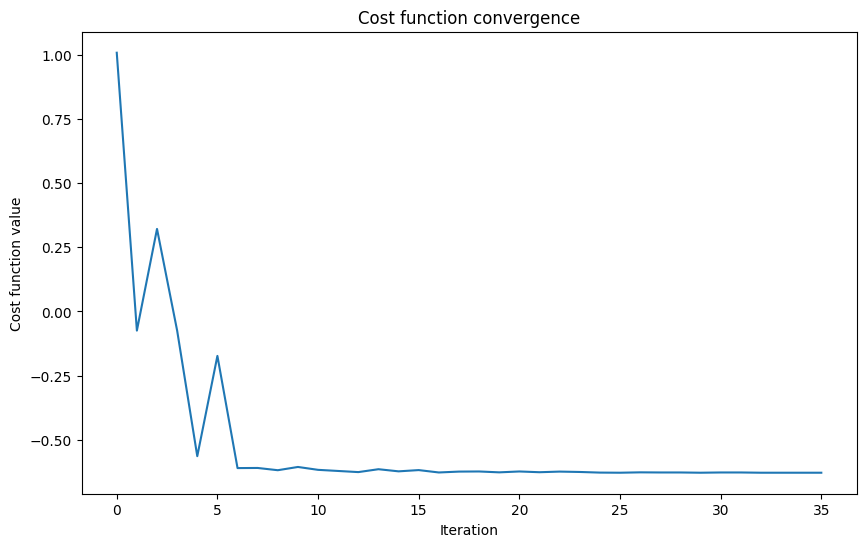

In [4]:
import matplotlib.pyplot as plt

cost_list = [term[0] for term in result]

plt.figure(figsize=(10, 6))

plt.plot(range(len(cost_list)), cost_list)

plt.title("Cost function convergence")
plt.xlabel("Iteration")
plt.ylabel("Cost function value")
plt.show()

When this is not necessary, it is possible to print only the final results:

In [5]:
optimal_energy = result[-1][0]
optimal_parameters = result[-1][1]

print(f"Optimal energy: {optimal_energy}")
print(f"Optimal parameters: {optimal_parameters}")

Optimal energy: -0.62890625
Optimal parameters: {'angles': [2.076354916155163, -0.05136489800462069, 0.08074820307349632]}


The VQE algorithm outputs these key results:

- **Optimal energy**: The lowest energy found for the Hamiltonian, representing the ground state energy (minimal eigenvalue).
- **Optimal parameters**: The parameters of the quantum program that achieve the optimal energy, corresponding to rotation angles in the U-gate.
- **Eigenstate**: The quantum state associated with the optimal energy, given as probability amplitudes for the basis states.

### Summary and Exercise <a id="summary-exercise-vqe"></a>

You designed a parameterized quantum circuit capable of capturing a simple Hamiltonian. You initialized an `ExecutionSession` and used `minimize` to execute it, visualizing the results.


<details>
<summary>Exercise - Two Qubits VQE</summary>

Now, practice the implementation of a similar case to the previous example, but this time for two qubits, following the Hamiltonian:

$$ H = \frac{1}{2}I \otimes I + \frac{1}{2}Z \otimes Z - X \otimes X $$

**Use the last example to implement and execute VQE for this Hamiltonian.**

Code skeleton:

```python
HAMILTONIAN = QConstant("HAMILTONIAN", List[PauliTerm], [...]) #TODO: Complete Hamiltonian

@qfunc
def main(...) -> None:
    #TODO: Complete the function according to the instructions, choosing simple ansatz.

qprog = synthesize(synthesize)
show(qprog)

with ExecutionSession(qprog_1) as es:
    result = es.minimize(
        cost_function=HAMILTONIAN,
        initial_params={"params": [0.0] * n_params},
        max_iteration=200,
    )


```
</details>

### Read More <a id="read-more-vqe"></a>

Further reading from the reference manual:
  - [Execution Primitives](https://docs.classiq.io/latest/user-guide/execution/ExecutionSession/)

## Using the PyTorch Integration

Classiq integrates with PyTorch, enabling the seamless development of quantum machine learning and hybrid classical quantum machine learning models. This integration leverages PyTorch's powerful machine learning capabilities alongside quantum computing.

<details>
<summary>Note on PyTorch Installation:</summary>

To properly install and run PyTorch locally, check [this page](https://pytorch.org/get-started/locally/).

</details>


### Workflow

1. **Defining the Model**
    - **1.1**: Define the quantum model and synthesize it into a quantum program.
    - **1.2**: Define the execute and post-process callables.
    - **1.3**: Create a `torch.nn.Module` network.
2. **Choosing the Dataset, Loss Function, and Optimizer**
3. **Training the Model**
4. **Testing the Model**


If you are not familiar with PyTorch, read the following documentation:

<details>
<summary>PyTorch Documentation</summary>

- [Creating Models](https://pytorch.org/tutorials/beginner/basics/quickstart_tutorial.html#creating-models)
- [Building Neural Networks](https://pytorch.org/tutorials/beginner/basics/buildmodel_tutorial.html)
- [Optimizing Model Parameters](https://pytorch.org/tutorials/beginner/basics/quickstart_tutorial.html#optimizing-the-model-parameters)
- [Tensors](https://pytorch.org/tutorials/beginner/basics/tensorqs_tutorial.html)
- [Datasets and DataLoaders](https://pytorch.org/tutorials/beginner/basics/data_tutorial.html)

</details>


### Example - Demonstrate PyTorch Integration with Classiq <a id="example-code-demonstrating-pytorch-integration-with-classiq"></a>

This example demonstrates PyTorch integration using a simple parameterized quantum model.

It utilizes one input from the user and one weight, while using one qubit in the model. The goal of the learning process is to determine the correct angle for an RX gate to perform a "NOT" operation. (Spoiler alert: The correct answer is $\pi$.)


The dataset `DATALOADER_NOT` is used, as defined [here](https://docs.classiq.io/latest/user-guide/applications/qml/qnn/datasets/). 
`DatasetXor` is also available from the link for further practice.

In [6]:
from classiq import *
from classiq.applications.qnn.datasets import DATALOADER_NOT

for data, label in DATALOADER_NOT:
    print(f"--> Data for training:\n{data}")
    print(f"--> Corresponding labels:\n{label}")

--> Data for training:
tensor([[0.0000],
        [3.1416]])
--> Corresponding labels:
tensor([0., 1.])


This dataset contains two items. The first item indicates no rotation (`0.0000`) and is labeled as 0, indicating the state $|0\rangle$. The second item indicates a rotation of `3.1416` and is labeled as 1, indicating the state $|1\rangle$.

Read an explanation on creating PyTorch datasets here: 
- [Creating a custom dataset for your files](https://pytorch.org/tutorials/beginner/basics/data_tutorial.html#creating-a-custom-dataset-for-your-files)
- [Writing custom datasets, dataLoaders, and transforms](https://pytorch.org/tutorials/beginner/data_loading_tutorial.html)

##### Step 1.1 - Define the Quantum Model and Synthesize It into a Quantum Program
<a id="step-11-define-the-quantum-model-and-synthesize-it-into-a-quantum-program"></a>

The first part of the parameterized quantum model has an encoding section, which loads input data ($|0\rangle$ or $|1\rangle$) into the parameterized quantum model:


In [7]:
@qfunc
def encoding(theta: CReal, q: QArray) -> None:
    RX(theta=theta, target=q[0])

The second part is the `mixing` function, which includes an adjustable parameter for training the RX gate to act later as a NOT gate:

In [8]:
@qfunc
def mixing(theta: CReal, q: QArray) -> None:
    RX(theta=theta, target=q[0])

Combining the two functions into the `main` function:

In [9]:
@qfunc
def main(input_0: CReal, weight_0: CReal, res: Output[QArray]) -> None:
    allocate(1, res)
    encoding(theta=input_0, q=res)  # Loading input
    mixing(theta=weight_0, q=res)  # Adjustable parameter

Finally, create a model, synthesize it, and display it in the IDE:

In [10]:
write_qmod(main, "qnn_with_pytorch")
qprog_2 = synthesize(main)
show(qprog_2)

Quantum program link: https://platform.classiq.io/circuit/2zMxqr678qnz8gGTlndDwtpyXcT


##### Step 1.2 - Define the Execute and Postprocess Callables

Before using the quantum layer (QLayer), define the `execute` and `post-processing` functions. These functions are essential for integrating the quantum layer in a PyTorch neural network, as classical layers require classical data as input. This means that only after executing the QLayer (the ansatz) and post-processing the results the data can be further used in other layers of the neural network or be output.

The `execute` function is straightforward. It takes the quantum program (here, the QLayer) and its parameters, and executes it:

In [11]:
from classiq.applications.qnn.types import (
    MultipleArguments,
    ResultsCollection,
    SavedResult,
)


def execute(
    quantum_program: QuantumProgram, arguments: MultipleArguments
) -> ResultsCollection:
    return execute_qnn(quantum_program, arguments)

In general, the `post_process` function is needed to prepare the execution results for output or for loss calculation during the training phase.

In this specific example, it returns the probability of measuring $|0\rangle$. This function assumes that only the differentiation between the single state $|0\rangle$ and all other states is relevant. If a different differentiation is needed, modify this function accordingly.

In [12]:
import torch


def post_process(result: SavedResult) -> torch.Tensor:
    """
    Take in a `SavedResult` with `ExecutionDetails` value type, and return the
    probability of measuring |0> which equals the amount of `|0>` measurements
    divided by the total number of measurements.
    """
    counts: dict = result.value.counts
    # The probability of measuring |0>
    p_zero: float = counts.get("0", 0.0) / sum(counts.values())
    return torch.tensor(p_zero)

Using these functions allows QLayers and PyTorch layers to be properly integrated into the same neural network.

##### Step 1.3 - Create a torch.nn.Module Network

Define the `torch.nn.Module` class with a single `QLayer` as follows:

In [13]:
from classiq.applications.qnn import QLayer


class Net(torch.nn.Module):
    def __init__(self, *args, **kwargs) -> None:
        super().__init__()
        self.qlayer = QLayer(
            qprog_2,  # the quantum program, the result of `synthesize()`
            execute,  # a callable that takes
            # - a quantum program
            # - parameters to that program (a tuple of dictionaries)
            # and returns a `ResultsCollection`
            post_process,  # a callable that takes
            # - a single `SavedResult`
            # and returns a `torch.Tensor`
            *args,
            **kwargs
        )

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        x = self.qlayer(x)
        return x


model = Net()

In `self.qlayer = QLayer(...)`, define the only layer in the neural network as a single QLayer. Specify the previously defined `quantum_program`, `execute`, and `post_process` as arguments for the layer. Finally, create the neural network and assign it to the variable `model`.

#### Step 2 - Choose a Dataset, Loss Function, and Optimizer

For the loss function and optimizer, use [L1Loss](https://pytorch.org/docs/stable/generated/torch.nn.L1Loss.html) and [SGD](https://pytorch.org/docs/stable/generated/torch.optim.SGD.html), respectively.

In [14]:
import torch.nn as nn
import torch.optim as optim

_LEARNING_RATE = 1

# choosing the data
data_loader = DATALOADER_NOT

# choosing the loss function
loss_func = nn.L1Loss()  # Mean Absolute Error (MAE)

# choosing the optimizer
optimizer = optim.SGD(model.parameters(), lr=_LEARNING_RATE)

<details>
<summary>Available Optimization Algorithms and Loss Functions</summary>

For details of the optimization algorithms and a comprehensive list of loss functions in PyTorch, refer to the official documentation:

- [Optimization Algorithms](https://pytorch.org/docs/stable/optim.html#algorithms)
- [Loss Functions](https://pytorch.org/docs/stable/nn.html#loss-functions)

</details>


#### Step 3 - Train and Evaluate <a id="step-3-train"></a>

Import `DataLoader`:

In [15]:
from torch.utils.data import DataLoader

A `DataLoader` in PyTorch efficiently iterates over datasets, handling batching, shuffling, and parallel data loading. It streamlines the process of training and evaluating models by managing data efficiently.

Now you are ready to define the training function. \
This simple example follows a loop similar to that recommended by PyTorch [here](https://pytorch.org/tutorials/beginner/blitz/neural_networks_tutorial.html#update-the-weights).


In [16]:
def train(
    model: nn.Module,
    data_loader: DataLoader,
    loss_func: nn.modules.loss._Loss,
    optimizer: optim.Optimizer,
    epoch: int = 5,  # About 40 epochs needed for full training
) -> None:
    for index in range(epoch):
        print(index, model.qlayer.weight)
        for data, label in data_loader:
            optimizer.zero_grad()

            output = model(data)

            loss = loss_func(output, label)
            loss.backward()
            optimizer.step()

Here, trained parameters are loaded for demonstration, and only one epoch is performed.\
You may comment on the following cell, change the number of epochs above, and expect about 40 epochs for full training for non-trained parameters.

In [17]:
with torch.no_grad():
    model.qlayer.weight.copy_(
        torch.tensor([3])
    )  # The value from the last step of the training

In [18]:
train(model, data_loader, loss_func, optimizer)

0 Parameter containing:
tensor([3.], requires_grad=True)
1 Parameter containing:
tensor([3.0732], requires_grad=True)
2 Parameter containing:
tensor([3.0977], requires_grad=True)
3 Parameter containing:
tensor([3.1343], requires_grad=True)
4 Parameter containing:
tensor([3.1343], requires_grad=True)


Great!Observe that the parameter is approximately equal to $\pi$. \
Now, test the network accuracy using the suggested method [here](https://stackoverflow.com/questions/52176178/pytorch-model-accuracy-test#answer-64838681).

In [19]:
def check_accuracy(model: nn.Module, data_loader: DataLoader, atol=1e-2) -> float:
    num_correct = 0
    total = 0
    model.eval()

    with torch.no_grad():  # Temporarily disable gradient calculation
        for data, labels in data_loader:
            # Let the model predict
            predictions = model(data)

            # Get a tensor of Booleans, indicating if each label is close to the real label
            is_prediction_correct = predictions.isclose(labels, atol=atol)

            # Count the number of `True` predictions
            num_correct += is_prediction_correct.sum().item()
            # Count the total evaluations
            #   the first dimension of `labels` is `batch_size`
            total += labels.size(0)

    accuracy = float(num_correct) / float(total)
    print(f"Test Accuracy of the model: {accuracy*100:.2f}%")
    return accuracy

In [20]:
check_accuracy(model, data_loader)

Test Accuracy of the model: 100.00%


1.0

**The results show an accuracy of 1**, indicating a 100% success rate in performing the required transformation (i.e., the network learned to perform an X-gate). You can further validate this by printing the value of `model.qlayer.weight`, which is a tensor of shape (1,1). After training, this value should be close to $\pi$.

### Summary and Exercise <a id="summary-exercise-pytorch"></a>

In this tutorial, you integrated a quantum layer in a PyTorch neural network, defined the necessary execution and post-processing functions, and trained the model using a simple dataset. You tested the network's accuracy using a recommended method. To explore further, try experimenting with different quantum circuits, datasets, and optimizers. Integrating more classic layers or more complex layers should be straightforward now for those with experience in PyTorch.

<details>
<summary>Exercise - Training U Gate</summary>

Now, for practice, implement a similar case to the last example, but this time train the U gate to act as a NOT gate instead of the Rx gate.  
How many parameters must you train?  
What must you change to accomplish this?

<details>
<summary>Hint</summary>
    
You only have to adapt `mixing` and `model`.

</details>
</details>


### Read More 
<a id="read-more-pytorch"></a>

Algorithms and application tutorials using the PyTorch integration:
- [Quantum Autoencoder](https://docs.classiq.io/latest/explore/algorithms/qml/quantum_autoencoder/quantum_autoencoder/)
- [QGAN](https://docs.classiq.io/latest/explore/algorithms/qml/qgan/qgan_bars_and_strips/)

Further reading from the reference manual: 
- [QNNs with Classiq](https://docs.classiq.io/latest/user-guide/applications/qml/qnn/)
- [QLayer](https://docs.classiq.io/latest/user-guide/applications/qml/qnn/qlayer/)

## Using QSVM Primitive 

Classiq also enables executing classification tasks using the **Quantum Support Vector Machine** (QSVM) module. This module leverages the principles of quantum computing to enhance traditional support vector machine algorithms, offering significant improvements in classification accuracy and efficiency. The QSVM module integrates seamlessly with the Classiq platform, allowing you to implement quantum-enhanced classification models effortlessly. By utilizing quantum kernels, the QSVM can handle complex datasets and capture intricate patterns that may be challenging for classical SVMs, making it a powerful tool for machine learning applications.



To understand how to use it and explore it further, examine this example: [QSVM with Classiq](https://docs.classiq.io/latest/explore/algorithms/qml/qsvm/qsvm/).

## References

<a id='eigenvaluesolver'>[1]</a>: [Peruzzo, A., McClean, J., Shadbolt, P., et al. (2014). A variational eigenvalue solver on a photonic quantum processor, *Nature Communications*](https://doi.org/10.1038/ncomms5213).

<a id='vqa'>[2]</a>: [Cerezo, M., Arrasmith, A., Babbush, R., et al. (2021). Variational quantum algorithms, *Nature Reviews Physics*, 3, 625–644](https://doi.org/10.1038/s42254-021-00348-9).

<a id='preprint'>[3]</a>: [Corresponding preprint arXiv:2104.02281](https://arxiv.org/abs/2104.02281).

<a id='CVaR'>[4]</a>: [Barkoutsos, Panagiotis Kl., et al. (2020). Improving variational quantum optimization using CVaR, *Quantum* 4, 256](https://doi.org/10.22331/q-2020-04-20-256).